In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
if not os.path.exists('figures/BCP'):
    os.makedirs('figures/BCP')


# the switching binomial generative model


In [3]:
t_titre = 35
t_label = 25
fig_width= 15
N_scan = 100
#N_scan = 10 # DEBUG

In [4]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'
observer = 'AM'
mode = 'pari'
exts = ['.svg'] #'.png', '.svg', '.pdf']
dpi = 400
from aSPEM import Analysis
import bayesianchangepoint as bcp
e = Analysis(observer=observer, mode=mode)

/!\ Le fichier Delete n'existe pas pour fct_velocity_2_step_False_whitening !


# the online BCP model: figures for the model

In [5]:
N_trials = 10
seed = 2020
np.random.seed(seed)
p0, r0 =  0.5, 1.0
trials = np.arange(N_trials)
p = np.random.rand(N_trials, 3)
p[:, 2] = 0
p[N_trials//2, 2] = 1

p[:N_trials//2, 1] = .1
p[N_trials//2:, 1] = .9

for trial in trials:
    p[trial, 0] =  p[trial, 1] > np.random.rand() # Bernouilli trial


    
tau = N_trials//2
h = 1/tau
p_bar, r_bar, beliefs = bcp.inference(p[:, 0], h=h, p0=p0, r0=r0)
p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='max', p0=p0)

In [6]:
r_hat

array([1., 2., 3., 4., 5., 6., 2., 3., 4., 5.])

In [7]:
r_true = r_hat.copy()
r_true[5] = 1

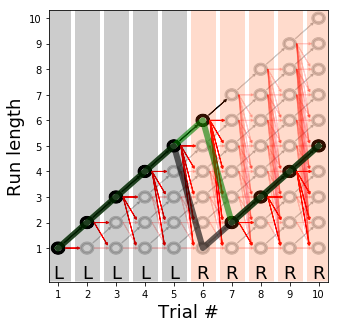

In [8]:
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

def arrow_1(ax, x, y, alpha):
    plt.arrow(x+r_cir, y+r_cir, 1-(r_cir*2)-(s_arrow/2), 1-(r_cir*2)-(s_arrow/2),
              head_width=s_arrow, head_length=s_arrow, fc=c_f1, ec=c_f1, alpha=alpha)


def arrow_2(ax, x, y, alpha):
    for r in range(0, y+1) :
        if r==0 : a=0
        else :    a=r_cir

        plt.arrow(x+r_cir+(s_arrow/2), y, 1-(r_cir*2)-(s_arrow*2), -r+a,
                  head_width=s_arrow, head_length=s_arrow, fc=c_f2, ec=c_f2, alpha=alpha)


fig_width = 5
r_cir, lw_cir, s_arrow = 0.2, 3, 0.09
alpha = .2

c_f1, c_f2, c_cir = 'k', 'r', 'k'
labelsize = 18
num = N_trials

Cir, Cir_a = [], []
#trials = range(int(num*1.6180)+1)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), sharex=True)
#fig.set_figwidth = 3
#fig.set_figheight = 3

for x in trials:
    if x < num: runlengths = range(x+1)
    else:       runlengths = range(num)
    max_r = num-1
    
    for r in runlengths:
        if r==r_hat[x]-1 : Cir += [Wedge((x, r), r_cir, 0, 360, width=r_cir/10)]
        else :             Cir_a += [Wedge((x, r), r_cir, 0, 360, width=r_cir/10)]

        if x < N_trials-1 :
            if r==r_hat[x]-1 : a=1
            else :             a=alpha
            arrow_1(ax, x, r, alpha=a)
            arrow_2(ax, x, r, alpha=a)

    ax.vlines(x, -1.3, (num+0.3), color=(p[x, 0], p[x, 0]*0.3, 0), lw=25, alpha=0.2)
    if p[x, 0]==0 : t='L'
    else :          t='R'
    ax.text(x, -1, t, ha='center', va='center', fontsize=labelsize)
    
ax.add_collection(PatchCollection(Cir, color=c_cir, lw=lw_cir))
ax.add_collection(PatchCollection(Cir_a, color=c_cir, alpha=alpha, lw=lw_cir))

ax.plot(r_hat-1, lw=6, alpha=0.6, c=color_bcp_mean)
ax.plot(r_true-1, lw=6, alpha=0.6, c='k')

ax.tick_params(bottom=True, top=False, right=False, left=True)
ax.set_ylabel('Run length', fontsize=labelsize)
ax.set_xlabel('Trial #', fontsize=labelsize)
ax.set_xticks(trials)
ax.set_yticks(np.arange(0, N_trials))
ax.set_xticklabels(np.arange(1, N_trials+1))
ax.set_yticklabels(np.arange(1, N_trials+1))


ax.axis([-0.32, (num+0.32)-1, -1.32, (num+0.32)-1])
#for ext in exts: plt.savefig('figures/BCP/bcp_model_layer_%s%s' % (layer, ext))


plt.show()

In [9]:
figname = '3_BCP_model'
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

# chosen readout with a comparison with 'fixed'

In [10]:
figname = '3_BCP_readouts'
num_block = 0

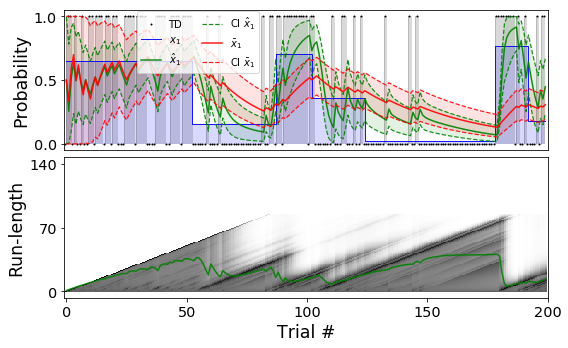

In [11]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.35,.15],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare='leaky', block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, fig_width=8, t_label=26,
                           leg_up=None)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)
#for ext in exts: fig.savefig('figures/BCP/BCP_mean_leaky_0'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

/usr/local/lib/python3.5/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


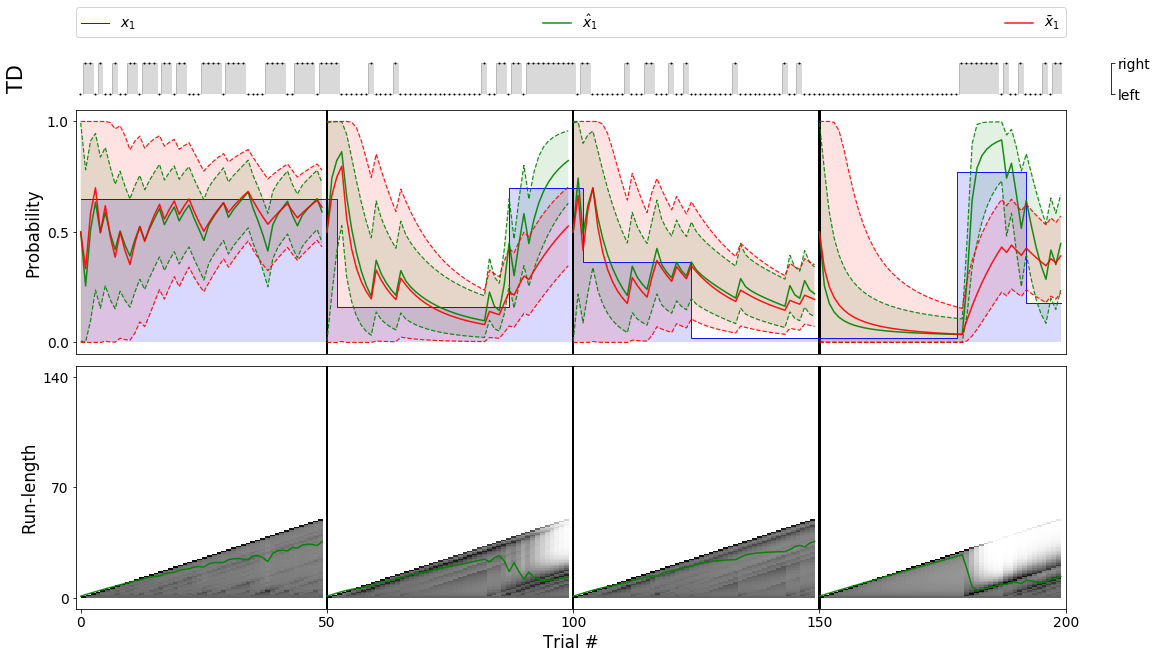

In [12]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.35,.15],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare='leaky', block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, TD=True,
                           fig_width=15, t_label=25, leg_up=True, pause=True) #fig_width=8, t_label=26, show_trial=False,leg_up=None)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)

for ext in exts: fig.savefig('figures/BCP/BCP_mean_leaky_0'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

/usr/local/lib/python3.5/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


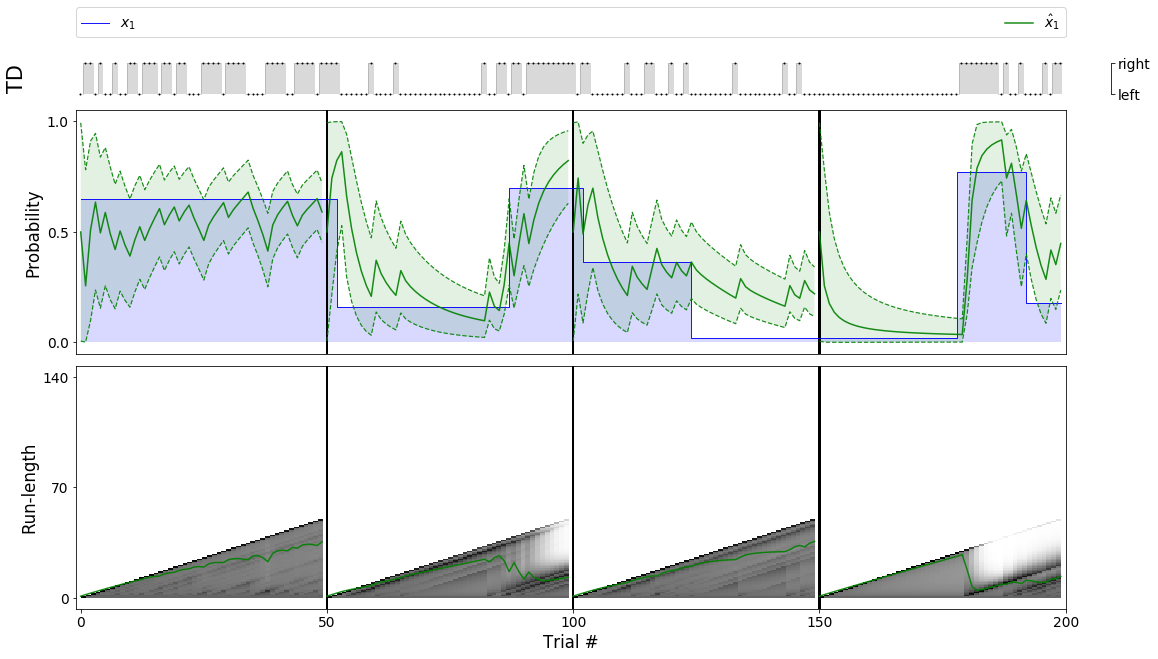

In [13]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.35,.15],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare=None, block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, TD=True,
                           fig_width=15, t_label=25, leg_up=True, pause=True) #fig_width=8, t_label=26, show_trial=False,leg_up=None)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)

for ext in exts: fig.savefig('figures/BCP/BCP_mean_0'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

/usr/local/lib/python3.5/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


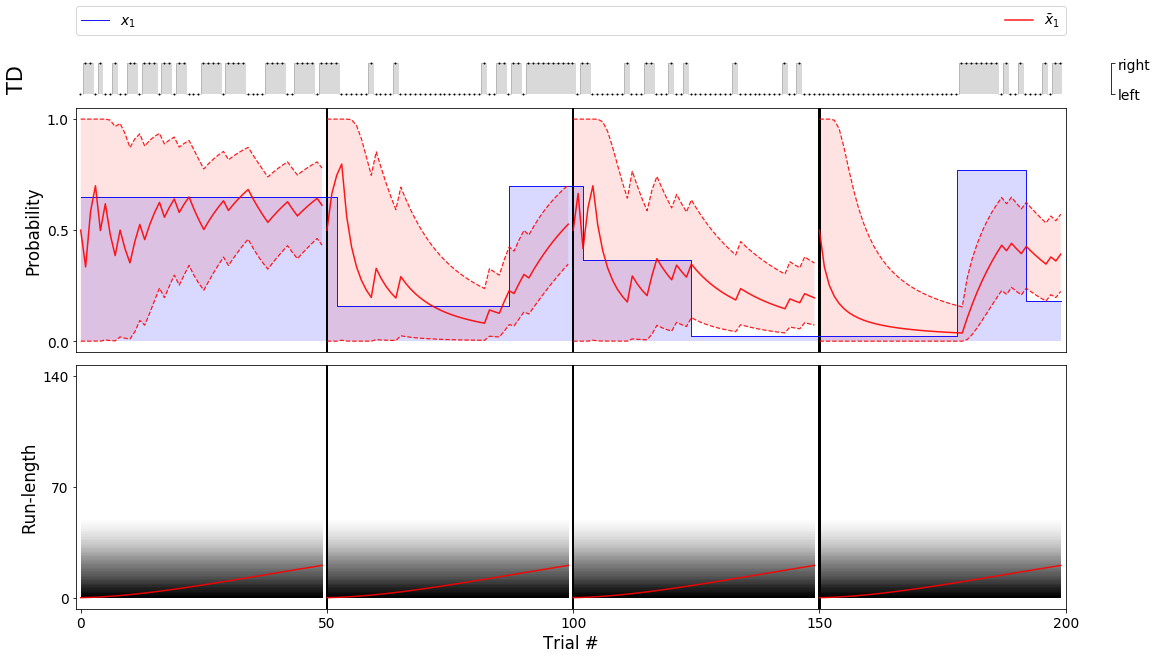

In [14]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.35,.15],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['leaky'], mode_compare=None, block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_fix, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, TD=True, label_bcp=r'$\bar{x}_1$',
                           fig_width=15, t_label=25, leg_up=True, pause=True) #fig_width=8, t_label=26, show_trial=False,leg_up=None)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)

for ext in exts: fig.savefig('figures/BCP/BCP_leaky_0'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

# evaluating the best hazard rate using a likelihood score

Vérifier tau !

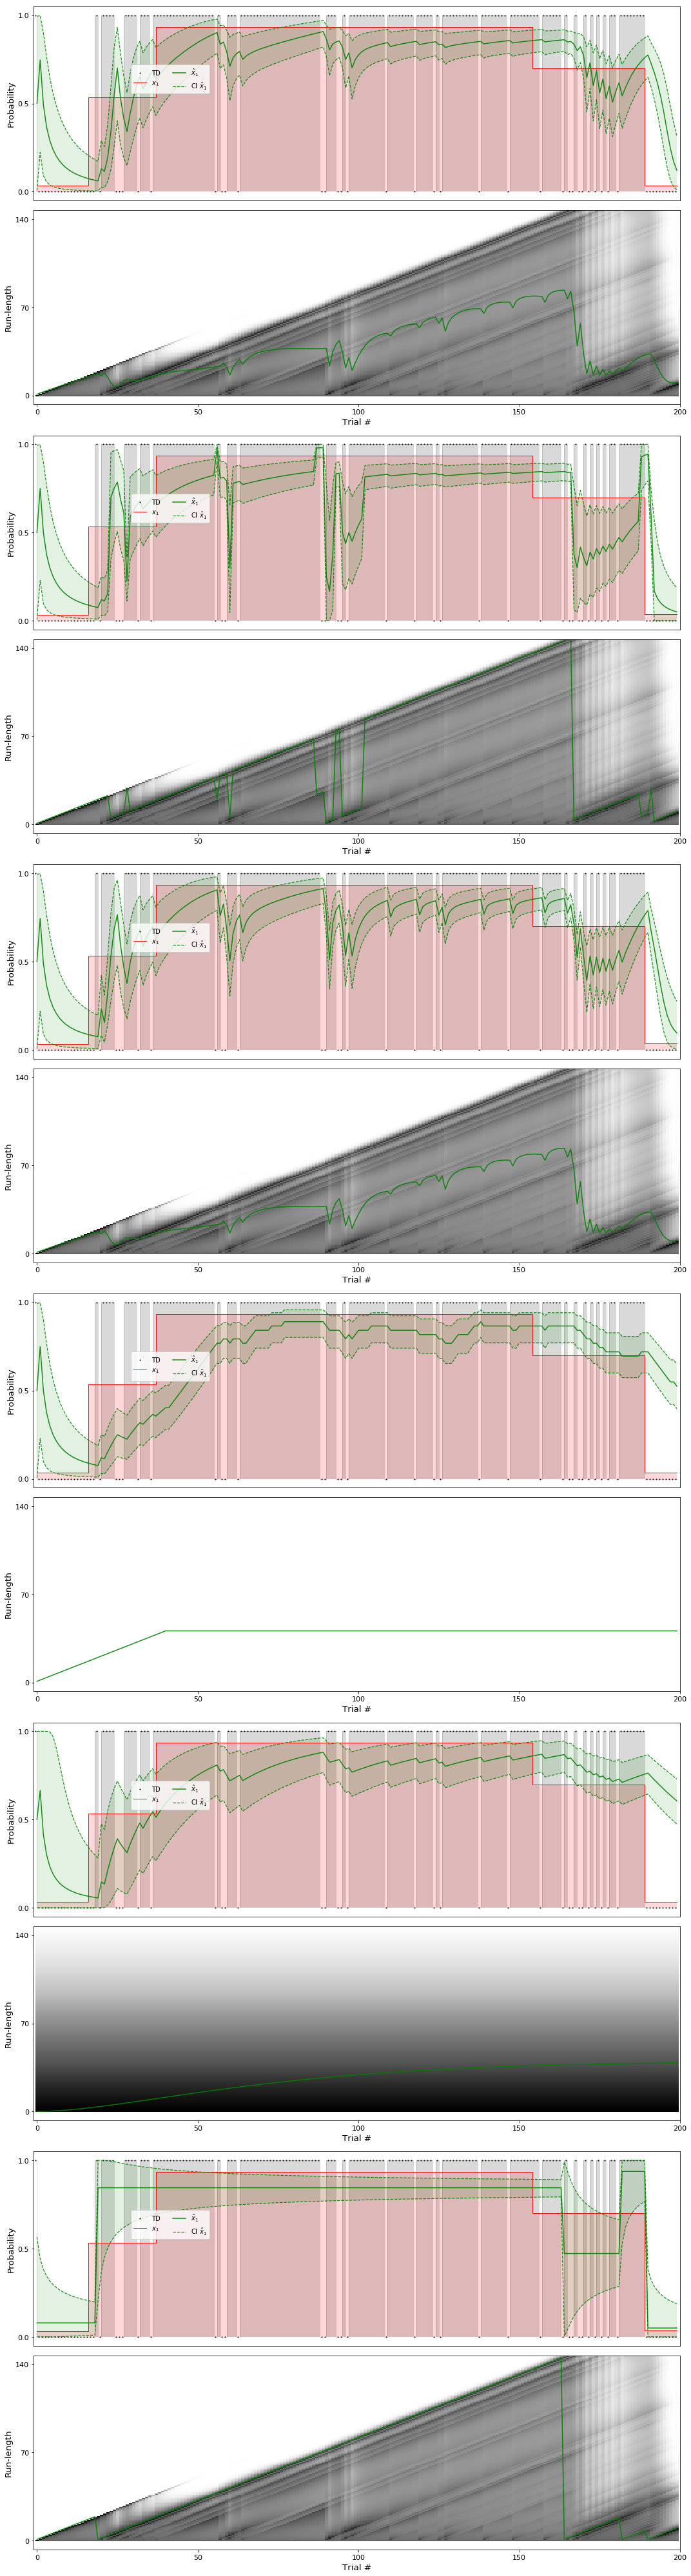

In [15]:
fig, ax1, ax2  = e.plot_bcp(show_trial=False, N_scan=0, block=2, trial=50)
for ext in exts: fig.savefig('figures/BCP/BCP_readouts' + ext, dpi=dpi)

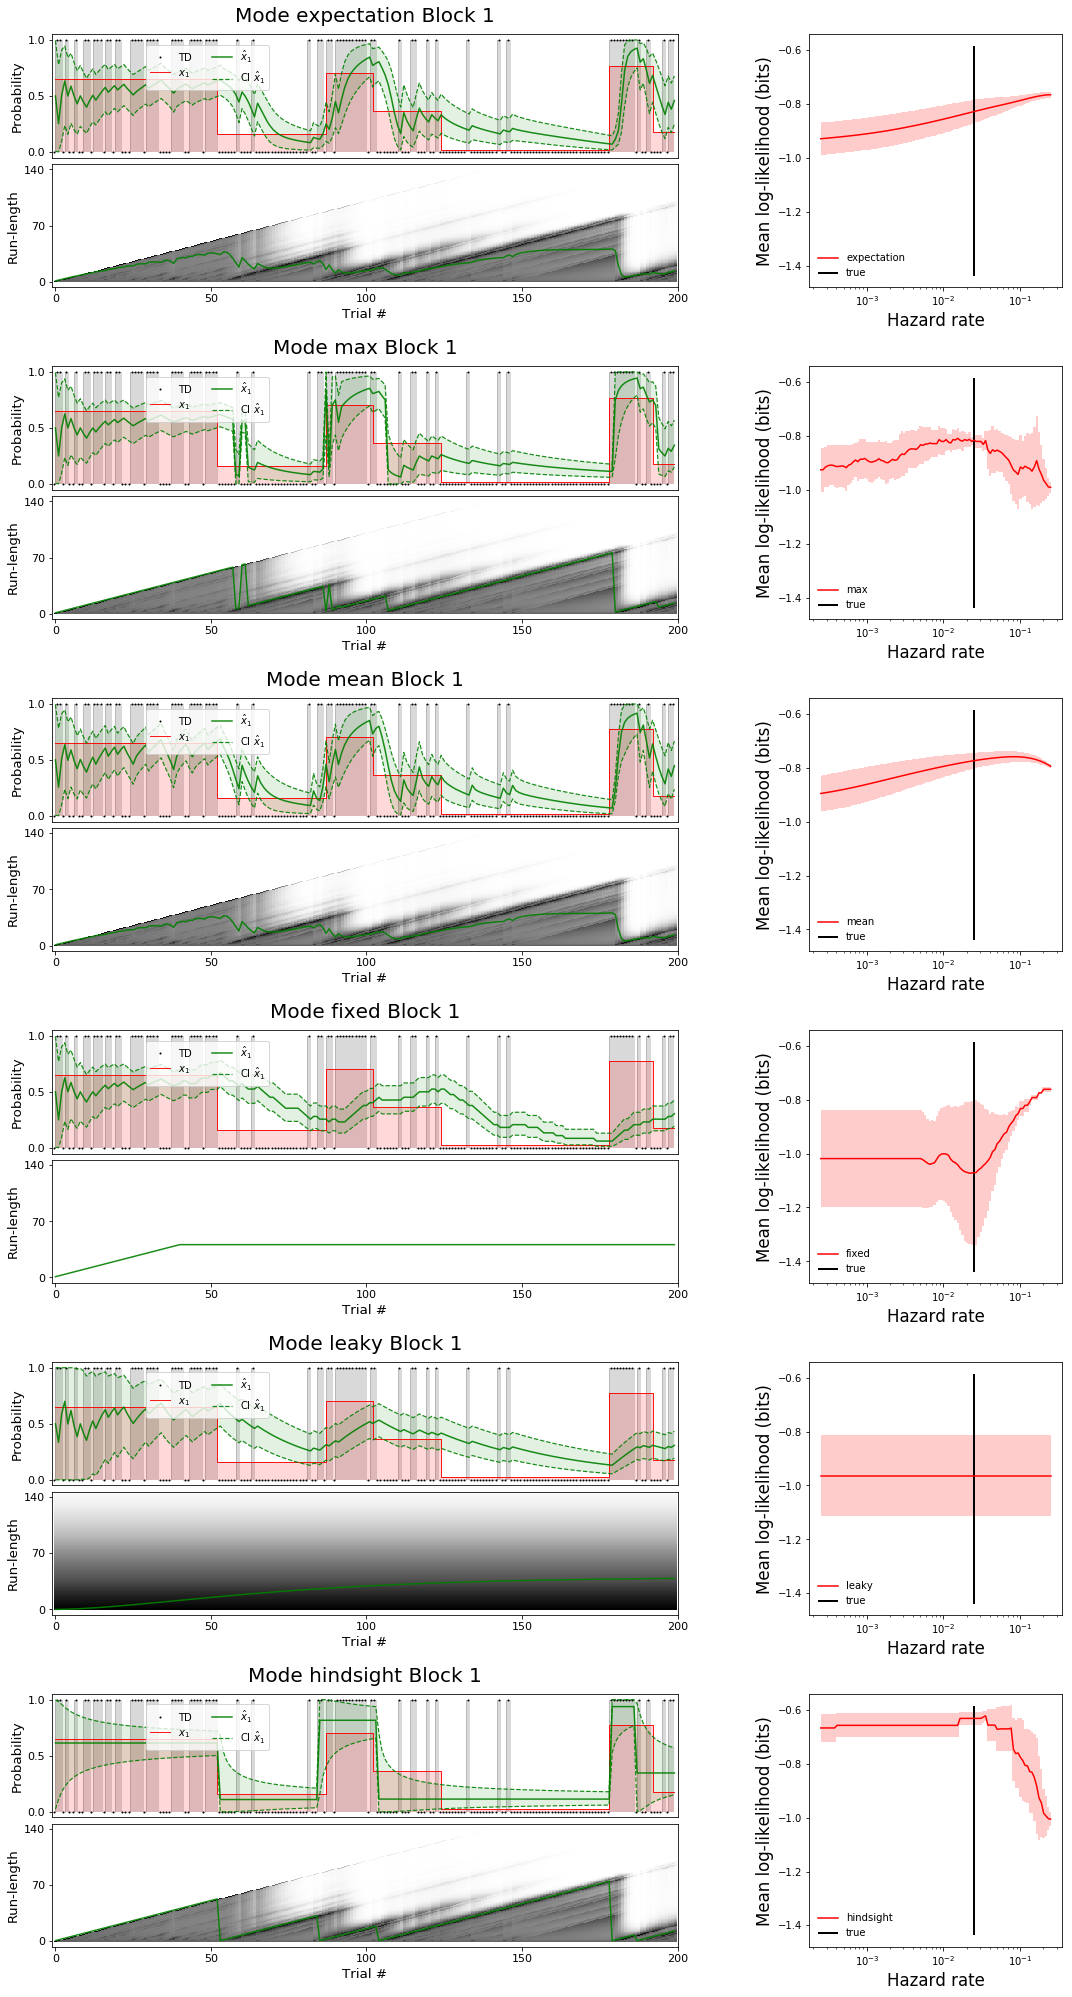

In [16]:
fig, ax1, ax2, ax3 = e.plot_bcp(show_trial=False, N_scan=N_scan)
for ext in exts: fig.savefig('figures/BCP/BCP_scan' + ext, dpi=dpi)

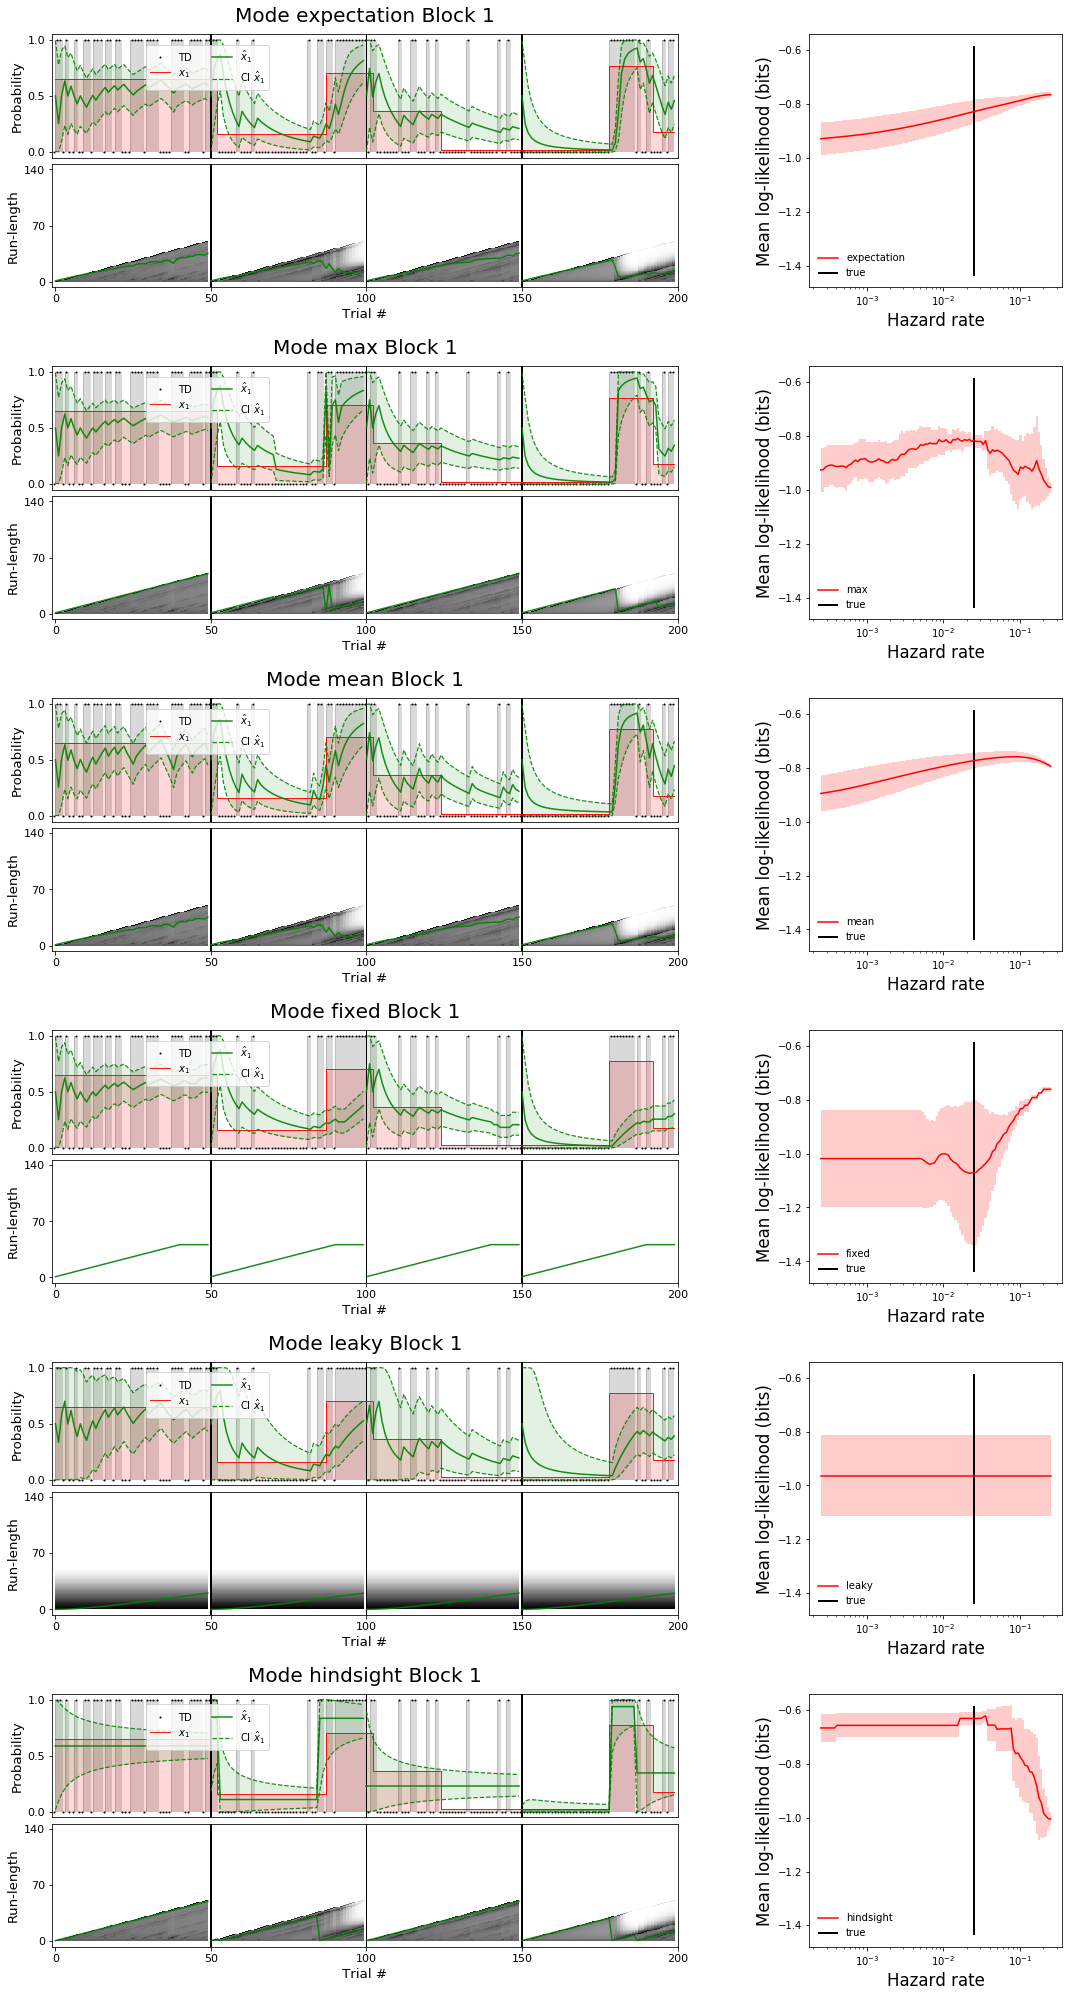

In [17]:
fig = e.plot_bcp(show_trial=False, N_scan=N_scan, pause=True)
#for ext in exts: fig.savefig('figures/BCP/BCP_scan' + ext, dpi=dpi)

TODO: plot pout chaque r la distriubtion Beta correspondant à $P(p |r) = B(p; p(r)*r, (1-p(r))*r)$

In [18]:
%ls {msfigpath}

1_A_Experiment_randomblock.pdf  2_results_enregistrement.svg
1_A_Experiment_randomblock.png  3_BCP_model.pdf
1_A_Experiment_randomblock.svg  3_BCP_model.png
1_B_protocol_recording.jpg      3_BCP_model.svg
1_B_protocol_recording.pdf      3_BCP_readouts.pdf
1_B_protocol_recording.png      3_BCP_readouts.png
1_B_protocol_recording.tiff     3_BCP_readouts.svg
1_B_Trace_moyenne.pdf           4_A_result_psycho_aSPEM.pdf
1_B_Trace_moyenne.png           4_A_result_psycho_aSPEM.png
1_B_Trace_moyenne.svg           4_A_result_psycho_aSPEM.svg
1_C_protocol_bet.jpg            4_B_result_psycho_bet.pdf
1_C_protocol_bet.pdf            4_B_result_psycho_bet.png
1_C_protocol_bet.png            4_B_result_psycho_bet.svg
1_C_protocol_bet.tiff           5_inter-individual_differences_fit.pdf
2_results_enregistrement.pdf    5_inter-individual_differences_fit.png
2_results_enregistrement.png    5_inter-individual_differences_fit.svg
